This attempt uses a Decision Tree Classifier rather than a regressor, as in the first attempt. 

The classifier is better for predicting binary values (compliance), however we get the same results in the end. May have to do with the tuning. 

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

sys.path.append("../utils")

import config

pd.set_option("display.max_columns", None)

In [40]:
def read_geojson_with_geopandas(file_path):
    gdf = gpd.read_file(file_path)
    return gdf


inspections_buffered_buildings_landcover = read_geojson_with_geopandas(
    "/capstone/wildfire_prep/data/inspections_data/cleaned_status_with_id/inspections_buffered_buildings_landcover.geojson"
)


In [41]:
# landcover codes are coming in with the format '582.0', so let's make them integers
inspections_buffered_buildings_landcover["maj_landcover_code"] = (
    inspections_buffered_buildings_landcover["maj_landcover_code"].astype("Int64")
)

# make ZIP code an integer too
inspections_buffered_buildings_landcover["zip_code"] = (
    inspections_buffered_buildings_landcover["zip_code"].astype("Int64")
)

inspections_buffered_buildings_landcover.dtypes


system_created        datetime64[ms]
inspection_status             object
latitude                     float64
longitude                    float64
address_number                object
street                        object
apt_number                    object
city                          object
county                        object
state                         object
zip_code                       Int64
country                       object
address_full                  object
date                  datetime64[ms]
inspection_date               object
structure_type                object
year                           int32
address_id                     int32
maj_landcover_code             Int64
geometry                    geometry
dtype: object

In [42]:
data1 = inspections_buffered_buildings_landcover.drop(
    columns=[
        "system_created",
        "latitude",
        "longitude",
        "address_number",
        "street",
        "apt_number",
        "city",
        "county",
        "state",
        "country",
        "address_full",
        "date",
        "inspection_date",
        "geometry",
    ]
)

data1.head()


,inspection_status,zip_code,structure_type,year,address_id,maj_landcover_code
0,Compliant,93463,School,2021,9978,582
1,Compliant,93463,School,2019,9978,582
2,Compliant,93463,School,2020,9978,582
3,Compliant,93463,School,2022,9978,582
4,Compliant,93463,School,2023,9978,582


In [43]:
categoricals = data1.select_dtypes(include=["object"])

for col in categoricals:
    le = LabelEncoder()
    data1[col] = le.fit_transform(data1[col].astype(str))

data1.head()


,inspection_status,zip_code,structure_type,year,address_id,maj_landcover_code
0,0,93463,11,2021,9978,582
1,0,93463,11,2019,9978,582
2,0,93463,11,2020,9978,582
3,0,93463,11,2022,9978,582
4,0,93463,11,2023,9978,582


In [44]:
# Using a Classifier rather than a regressor, for the binary value of 'compliance'

X = data1.drop("inspection_status", axis=1)
y = data1["inspection_status"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=808
)

clf = DecisionTreeClassifier(max_depth=5, random_state=808)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))




Accuracy: 0.9949238578680203
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12936
           1       0.50      0.02      0.03        66

    accuracy                           0.99     13002
   macro avg       0.75      0.51      0.51     13002
weighted avg       0.99      0.99      0.99     13002



In [50]:
param_grid = {
    "max_features": ["sqrt", 6, None],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf = RandomForestRegressor(random_state=808)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=2,
                      random_state=808)

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MSE on Test Set: 0.0049331943169294516


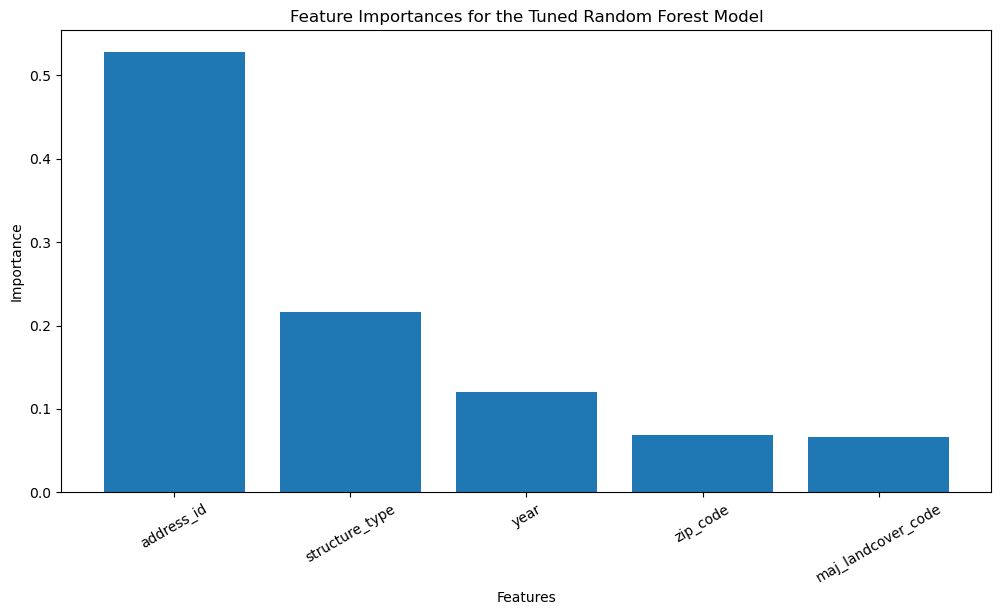

In [51]:
y_pred = best_rf.predict(X_test)

print("Best parameters:", grid_search.best_params_)

mse_value = mean_squared_error(y_test, y_pred)
print("MSE on Test Set:", mse_value)

importances = best_rf.feature_importances_

feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance["Feature"], feature_importance["Importance"])
plt.xticks(rotation=30)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances for the Tuned Random Forest Model")
plt.show()


In [45]:
#data1["predicted_compliance"] = clf.predict(X)


In [46]:
data1.head()

,inspection_status,zip_code,structure_type,year,address_id,maj_landcover_code
0,0,93463,11,2021,9978,582
1,0,93463,11,2019,9978,582
2,0,93463,11,2020,9978,582
3,0,93463,11,2022,9978,582
4,0,93463,11,2023,9978,582


In [47]:
# mismatches = data1.loc[data1['inspection_status'] != data1['predicted_compliance']]
# mismatches.head()

In [48]:
# compliant = data1.loc[data1['predicted_compliance'] == 0]
# noncompliant = data1.loc[data1["predicted_compliance"] == 1]

# print(compliant.shape)
# print(noncompliant.shape)

# print(data1['inspection_status'].value_counts())